# What happens if we modfiy the salary?

First: Create model similar to `exp_regression.ipynb`

In [1]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, FIG_DIR, COURSES, SECTORS
from src.dataLoading import getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalaries
from src.model import fitVarModel, predict
import numpy as np
from statsmodels.tsa.api import VAR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import bundles

In [2]:
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

inflationAdjustedGrossSalary = getInflationAdjustedBruttoSalaries(SECTORS)
sallaries = getSalaries()

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
3798.0 -> 3712.609970674487
3818.5 -> 3732.649071358749
3905.0 -> 3713.2337559097946
3951.5 -> 3757.4502398149943
4001.5 -> 3797.4000460725265
4072.5 -> 3864.7786299213703
4093.0 -> 3841.971325187983
4108.0 -> 3856.051356919676
4194.0 -> 3840.7579240793984
4268.5 -> 3908.9831184866266
4365.5 -> 3911.754635400449
4488.5 -> 4021.9701479773025
4474.0 -> 3945.8437621538624
4500.5 -> 3969.2154339681397
4554.5 -> 3984.961039163173
4653.0 -> 4071.1436415031826
4724.0 -> 4104.533377567224
4799.5 -> 4170.132926679486
4769.0 -> 4127.123950771447
4849.5 -> 4196.789179967736
4905.5 -> 4174.2890

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Build the model (once again)

In [3]:
LAGS = 4
PREDICTION_STPES = 2

In [4]:
dataset = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
results = fitVarModel(totalStudents, inflationAdjustedGrossSalary, graduatesInBW, lags=LAGS)
forecast = predict(results, 10)

/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


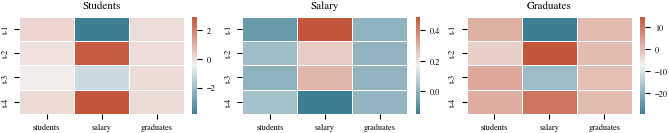

In [5]:
params = results.params.to_numpy()

paramsMatrices = []
titles = ['Students', 'Salary', 'Graduates']

for i in range(LAGS - 1):
    reshapedCoefficients = params[1:, i].reshape((LAGS, 3))
    df = pd.DataFrame(reshapedCoefficients)
    df.columns = ['students', 'salary', 'graduates']
    df.index = ['t-1', 't-2', 't-3', 't-4']
    paramsMatrices.append(df)

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))

fig, axs = plt.subplots(1, 3)

for i, df in enumerate(paramsMatrices):
    sns.heatmap(df, linewidths=0.5, ax=axs[i], cmap=sns.diverging_palette(220, 20, as_cmap=True))
    axs[i].set_title(titles[i])


plt.savefig(FIG_DIR + '/params.pdf')
plt.show()